<a href="https://colab.research.google.com/github/JalenCai/Lab09/blob/main/Sepsis_USC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score, auc

In [2]:
# View the CSV file
file_path = ('/content/drive/MyDrive/USC Sepsis Data/df.csv')
df = pd.read_csv(file_path)
df.head()

,AAMDC,AASDHPPT,ABAT,ABCB10,ABCC2,ABCC4,ABCC9,ABCD3,ABCF1,ABHD13,...,ZRANB1,ZRANB2,ZSCAN2,ZSCAN29,ZSCAN32,ZSWIM8,ZW10,ZYG11B,ZZZ3,Class
0,7.302388,6.915275,3.880092,7.265628,3.524147,7.643898,4.941341,6.194789,6.798725,3.103448,...,7.290934,6.870031,4.501835,4.688715,7.762803,10.065096,7.719833,10.124158,7.126248,1
1,6.542649,6.049383,4.261556,6.668126,6.440577,8.045913,4.633716,5.779594,6.607670,4.384160,...,7.879330,7.090486,3.623360,5.467375,7.823195,10.677917,7.011917,10.424676,6.418867,0
2,6.988663,6.311620,5.817879,7.171268,4.780891,7.651797,3.805097,5.748838,6.802868,5.203732,...,8.068296,7.098032,5.544115,5.294168,7.761181,10.109725,7.519756,10.265863,6.998565,0
3,7.150255,6.560918,4.827277,7.124046,3.199669,7.161897,4.001520,5.872608,6.694096,3.056027,...,7.637248,7.169608,4.651321,4.865155,7.904202,9.781929,7.766247,9.663125,7.105418,0
4,6.509508,6.592467,5.487019,6.648482,3.878681,7.776908,4.488685,6.216506,6.082014,4.766600,...,9.381785,7.160902,3.046281,4.754909,8.046215,10.336220,6.798046,9.955113,6.572653,0


Accuracy:, 0.7483870967741936
Confusion Matrix:
[[102   8]
 [ 31  14]]
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.93      0.84       110
           1       0.64      0.31      0.42        45

    accuracy                           0.75       155
   macro avg       0.70      0.62      0.63       155
weighted avg       0.73      0.75      0.72       155



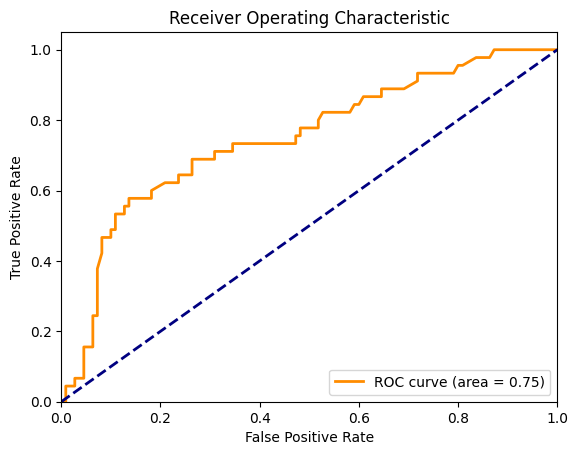

In [11]:
# Load the CSV file
file_path = ('/content/drive/MyDrive/USC Sepsis Data/df.csv')
df = pd.read_csv(file_path)

# Extract features and labels
features = df.drop('Class', axis=1)
labels = df['Class']

# Remove duplicate feature names
features = features.loc[:, ~features.columns.duplicated()]

# Convert all gene expression columns to numeric, handling non-numeric values
features = features.apply(pd.to_numeric, errors='coerce')

# Handle any remaining non-numeric values (e.g., fillna with median or mode)
features = features.fillna(features.median())

# Encode the labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Balance the dataset using SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

param = {'n_estimators': 100, 'max_leaf_nodes': 125, 'max_depth': 20}
# Train the Random Forrest
forest_model = RandomForestClassifier(random_state=0, **param)
forest_model.fit(X_train_balanced, y_train_balanced)

# Make predictions
Sepsis_preds = forest_model.predict(X_test)
Sepsis_preds_proba = forest_model.predict_proba(X_test)[:, 1]

# Evaluate the model
accuracy = accuracy_score(y_test, Sepsis_preds)
conf_matrix = confusion_matrix(y_test, Sepsis_preds)
class_report = classification_report(y_test, Sepsis_preds)

print(f"Accuracy:, {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

# Generate ROC curve and calculate AUC
fpr, tpr, _= roc_curve(y_test, Sepsis_preds_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [4]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [90, 100, 125],
    'max_depth': [20],
    'max_leaf_nodes': [150, 100, 125],

}

# Initialize the Random Forrest Classifier
forest_model = RandomForestClassifier()

# Initialize Grid Search
grid_search = GridSearchCV(estimator=forest_model, param_grid=param_grid, cv=5, scoring='f1_weighted', verbose=1, n_jobs=1)

# Fit the model
grid_search.fit(X_train_balanced, y_train_balanced)

# Get the best parameters and best model
best_params = grid_search.best_params_
print(f'Best Parameters: {best_params}')

# Train the model with the best parameters
best_forest_model = grid_search.best_estimator_

# Make predictions
Sepsis_preds = best_forest_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, Sepsis_preds)
conf_matrix = confusion_matrix(y_test, Sepsis_preds)
class_report = classification_report(y_test, Sepsis_preds)

print(f"Accuracy:, {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best Parameters: {'max_depth': 20, 'max_leaf_nodes': 100, 'n_estimators': 125}
Accuracy:, 0.7483870967741936
Confusion Matrix:
[[101   9]
 [ 30  15]]
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.92      0.84       110
           1       0.62      0.33      0.43        45

    accuracy                           0.75       155
   macro avg       0.70      0.63      0.64       155
weighted avg       0.73      0.75      0.72       155



Accuracy:, 0.7548387096774194
Confusion Matrix:
[[102   8]
 [ 30  15]]
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.93      0.84       110
           1       0.65      0.33      0.44        45

    accuracy                           0.75       155
   macro avg       0.71      0.63      0.64       155
weighted avg       0.74      0.75      0.73       155



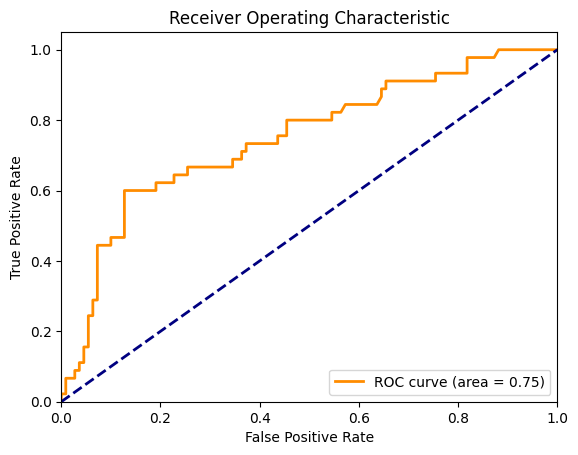

In [9]:
from xgboost import plot_importance

# Load the CSV file
file_path = ('/content/drive/MyDrive/USC Sepsis Data/df.csv')
df = pd.read_csv(file_path)

# Extract features and labels
features = df.drop('Class', axis=1)
labels = df['Class']

# Remove duplicate feature names
features = features.loc[:, ~features.columns.duplicated()]

# Convert all gene expression columns to numeric, handling non-numeric values
features = features.apply(pd.to_numeric, errors='coerce')

# Handle any remaining non-numeric values (e.g., fillna with median or mode)
features = features.fillna(features.median())

# Encode the labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Balance the dataset using SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

param_dist = {'n_estimators': randint(50,500),
              'max_leaf_nodes': randint(50, 200),
              'max_depth': randint(10, 30)}

# Create a random forest classifier
forest_model = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(forest_model,
                                 param_distributions = param_dist,
                                 n_iter=5,
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(X_train_balanced, y_train_balanced)

# Make predictions
Sepsis_preds = rand_search.predict(X_test)
Sepsis_preds_proba = rand_search.predict_proba(X_test)[:, 1]

# Evaluate the model
accuracy = accuracy_score(y_test, Sepsis_preds)
conf_matrix = confusion_matrix(y_test, Sepsis_preds)
class_report = classification_report(y_test, Sepsis_preds)

print(f"Accuracy:, {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

# Generate ROC curve and calculate AUC
fpr, tpr, _= roc_curve(y_test, Sepsis_preds_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

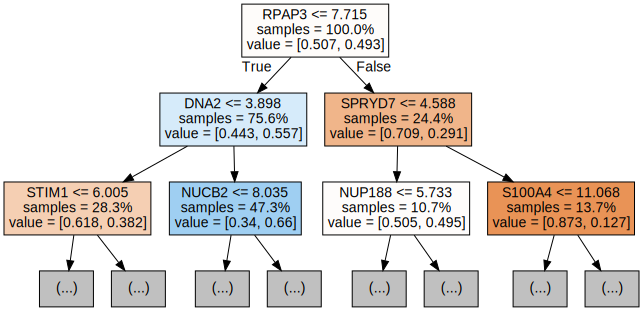

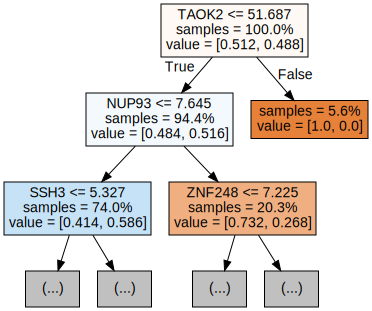

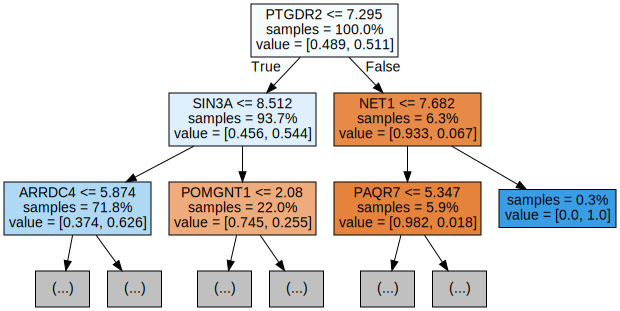

In [12]:
# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

for i in range(3):
    tree = forest_model.estimators_[i]
    dot_data = export_graphviz(tree,
                                                          feature_names=X_train.columns,
                                                          filled=True,
                                                          max_depth=2,
                                                          impurity=False,
                                                          proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)